## MIQP (Mixed-Integer Quadratic Programming) — Didactic Explanation
https://www.fico.com/fico-xpress-optimization/docs/latest/getting_started/dhtml/chap7_sec_c7s3.html

**What is MIQP?**
MIQP is a quadratic optimization problem that includes integer (often binary) decision variables. In our portfolio context, MIQP is used to encode constraints such as:

- **Cardinality constraint:** limit the number of selected assets (binary `y_i` indicates if asset `i` is included)
- **Minimum/maximum weights when selected:** e.g., `w_i >= min_w_if_selected * y_i`
- **Sector constraints or ESG constraints:** by summing contributions across selected assets or sectors

**Why use MIQP?**
These real-world constraints make the optimization non-convex (due to integrality) and more realistic for actionable portfolios (you cannot hold infinitesimal positions in many assets). Solvers like FICO Xpress can handle MIQP directly.

**Implementation notes:**
- `esg_min`, `target_return`, `max_w_per_asset`, `min_w_if_selected` etc. are problem parameters.
- The implementation builds the MIQP model, adds variables and constraints, and solves it to obtain a discrete-constrained portfolio.

Below the notebook keeps the original MIQP code but with added comments and short clarifications of each constraint.


In [1]:
import os
import numpy as np
import pandas as pd
import xpress as xp
from xpress.enums import MIPStatus
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ['XPAUTH_PATH'] = 'xpauth.xpr'

## Data Loading

This section defines the dataset path and configuration flags used throughout the analysis.

- `data_path`: folder where dataset files are located.
- `data_size`: selects which data subfolder ('8' for 8 assets, '100' or '2500').
- `cleaned`: whether to point to the cleaned dataset variant.

We keep these variables as parameters to make the notebook reproducible.


In [2]:
# Configuration: dataset path and flags
# These parameters make the notebook flexible for different data sizes/variants.

data_path = '/Users/gio/Documents/VsCode/FICO_case_HTW2025'
data_size = '100'
cleaned = True

clean = '_cleaned' if cleaned else ''

## Data Preprocessing

Here we load metadata or share/stock lists and other auxiliary files. Typical steps after loading:
- align indices (tickers/assets)
- filter assets (e.g., exclude delisted or low-liquidity names)
- ensure return columns and sector/ESG info are available

See 'Data Cleaning.ipynb' for details.

In [3]:
df_info = pd.read_csv(f'{data_path}/data{data_size}/shares{data_size}{clean}.csv', index_col='Stock')
df_price = pd.read_csv(f'{data_path}/data{data_size}/stockprices{data_size}{clean}.csv', index_col='Stock')

df_info = df_info.loc[:, ~df_info.columns.str.contains('^Unnamed')]
df_price = df_price.loc[:, ~df_price.columns.str.contains('^Unnamed')]
df_price = df_price.astype(float)

df_return = np.log(df_price.T / df_price.T.shift(1)).dropna().T
df_cov = df_return.T.cov()

display(df_info.head())
display(df_price.head())
display(df_return.head())
display(df_cov.head())

,Return,Sector,ESG score
Stock,,,
Stock_1,0.1598,Healthcare,73.0
Stock_2,0.2018,Technology,95.0
Stock_3,0.0883,Consumer Goods,63.0
Stock_4,0.2048,Finance,68.0
Stock_5,0.0818,Finance,65.0


,Day_129,Day_154,Day_155,Day_178,Day_179,Day_181,Day_182,Day_253,Day_287,Day_288,...,Day_4991,Day_4992,Day_4993,Day_4994,Day_4995,Day_4996,Day_4997,Day_4998,Day_4999,Day_5000
Stock,,,,,,,,,,,,,,,,,,,,,
Stock_1,25.40,39.08,42.69,63.40,63.89,57.05,52.95,149.55,168.13,179.45,...,1.48,1.46,1.31,1.21,1.14,1.26,1.38,1.35,1.48,1.46
Stock_2,71.93,77.11,76.09,27.89,26.35,23.45,29.64,21.83,33.85,33.01,...,1.08,1.19,1.07,1.02,1.00,1.02,1.21,1.07,1.23,1.08
Stock_3,71.17,51.04,51.68,61.31,59.67,63.18,60.90,57.83,61.04,62.01,...,44.84,41.68,40.69,37.08,35.58,36.29,36.54,36.58,38.14,37.16
Stock_4,30.41,65.30,61.17,87.41,90.10,100.85,105.48,39.73,28.94,25.52,...,2.68,2.41,2.51,2.67,2.82,3.05,3.33,2.82,2.91,2.80
Stock_5,114.56,79.68,79.84,67.46,66.45,68.04,62.80,52.02,59.02,56.95,...,1.45,1.51,1.43,1.44,1.36,1.37,1.40,1.43,1.38,1.27


,Day_154,Day_155,Day_178,Day_179,Day_181,Day_182,Day_253,Day_287,Day_288,Day_289,...,Day_4991,Day_4992,Day_4993,Day_4994,Day_4995,Day_4996,Day_4997,Day_4998,Day_4999,Day_5000
Stock,,,,,,,,,,,,,,,,,,,,,
Stock_1,0.430862,0.088354,0.395499,0.007699,-0.113235,-0.074580,1.038283,0.117107,0.065159,-0.034988,...,0.041385,-0.013606,-0.108409,-0.079407,-0.059592,0.100083,0.090972,-0.021979,0.091937,-0.013606
Stock_2,0.069540,-0.013316,-1.003649,-0.056800,-0.116598,0.234254,-0.305840,0.438654,-0.025128,0.012942,...,0.076961,0.096992,-0.106295,-0.047856,-0.019803,0.019803,0.170818,-0.122962,0.139356,-0.130053
Stock_3,-0.332462,0.012461,0.170872,-0.027114,0.057158,-0.036755,-0.051726,0.054022,0.015766,0.005147,...,-0.046196,-0.073079,-0.024039,-0.092905,-0.041294,0.019759,0.006865,0.001094,0.041762,-0.026031
Stock_4,0.764221,-0.065335,0.356953,0.030310,0.112714,0.044887,-0.976415,-0.316882,-0.125762,-0.027813,...,-0.109457,-0.106190,0.040656,0.061796,0.054658,0.078405,0.087831,-0.166235,0.031416,-0.038534
Stock_5,-0.363080,0.002006,-0.168490,-0.015085,0.023646,-0.080141,-0.188327,0.126248,-0.035703,0.044811,...,-0.006873,0.040546,-0.054435,0.006969,-0.057158,0.007326,0.021661,0.021202,-0.035591,-0.083067


Stock,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5,Stock_6,Stock_7,Stock_8,Stock_9,Stock_10,...,Stock_91,Stock_92,Stock_93,Stock_94,Stock_95,Stock_96,Stock_97,Stock_98,Stock_99,Stock_100
Stock,,,,,,,,,,,,,,,,,,,,,
Stock_1,0.006310,-0.000017,-0.000004,-0.000156,-0.000048,-0.000047,0.000338,-9.157260e-05,0.000089,-0.000302,...,-0.000132,-0.000137,-0.000152,-0.000225,-7.907456e-05,-0.000126,0.000043,-0.000248,-0.000192,-0.000369
Stock_2,-0.000017,0.023329,0.000079,0.000031,0.000237,0.000051,0.000213,-4.700639e-07,0.000147,-0.000297,...,-0.000128,0.000153,-0.000071,0.000146,2.472371e-07,0.000034,-0.000121,0.000079,-0.000023,-0.000056
Stock_3,-0.000004,0.000079,0.001532,-0.000033,0.000018,-0.000035,-0.000019,3.743262e-06,-0.000066,0.000010,...,0.000022,-0.000047,0.000059,0.000231,-7.540838e-05,-0.000071,-0.000053,-0.000176,-0.000061,-0.000002
Stock_4,-0.000156,0.000031,-0.000033,0.006427,-0.000271,0.000161,-0.000079,1.079870e-05,0.000063,-0.000159,...,0.000053,0.000005,-0.000226,0.000004,-8.813506e-05,0.000055,-0.000047,-0.000284,-0.000026,0.000005
Stock_5,-0.000048,0.000237,0.000018,-0.000271,0.002273,0.000012,0.000223,3.402743e-05,-0.000027,-0.000055,...,0.000007,0.000010,0.000172,0.000143,-5.593546e-05,-0.000038,0.000019,0.000090,-0.000015,0.000229


## Expected Returns and Covariance Matrix

This block builds the expected return vector `mu` and the covariance matrix `Sigma`:

- `mu` is typically the vector of expected (or historical average) returns per asset.
- `Sigma` is the covariance matrix of asset returns (used in variance calculations).

These objects are the inputs to the quadratic Markowitz problem:
- minimize portfolio variance `w^T Sigma w` subject to a target return `w^T mu = r` and `sum(w)=1`.


## Efficient Frontier — Optimization Problem

For each target return `tr`, we solve the following **Quadratic Optimization Problem**:

\[
\begin{aligned}
\min_{w} \quad & w^T \Sigma w \\
\text{s.t.} \quad & \sum_i w_i = 1 \quad \text{(fully invested portfolio)} \\
& \sum_i \mu_i w_i = tr \quad \text{(target return)} \\
& 0 \leq w_i \leq 1 \quad \forall i \quad \text{(long-only, no short selling)} \\
\end{aligned}
\]

- **Decision variables**: portfolio weights \(w_i\) (fraction of wealth invested in asset \(i\))  
- **Objective**: minimize variance (risk) for the given expected return `tr`  
- **Constraints**:  
  - Fully invested portfolio (weights sum to 1)  
  - Expected return must equal the target return  
  - No short positions (weights between 0 and 1)  

By solving this problem for many values of `tr` between `mu.min()` and `mu.max()`, we trace out the **efficient frontier**.


In [4]:
mu = df_info.loc[df_cov.index, 'Return'].to_numpy()
Sigma = df_cov.loc[df_cov.index, df_cov.index].to_numpy()
Sigma = 0.5 * (Sigma + Sigma.T)

frontier = []  # list to store solutions (return, risk, weights, etc.)

# Sweep through 100 equally spaced target returns between min and max asset returns
for tr in tqdm(np.linspace(mu.min(), mu.max(), 100), total=100, desc="Building frontier"):
    
    # Create a new quadratic optimization problem with Xpress
    prob = xp.problem()
    prob.controls.outputlog = 0   # silence solver output
    prob.controls.maxtime = 10    # set max solve time in seconds
    
    # Define decision variables: portfolio weights w_i for each asset
    # bounded between 0 and 1 (long-only portfolio)
    w = [prob.addVariable(lb=0, ub=1, name=f'w{i}') for i in range(len(df_cov))]
    
    # Define the quadratic objective function: portfolio variance = w^T Σ w
    obj = xp.Sum([Sigma[i, j] * w[i] * w[j]
                  for i in range(len(df_cov))
                  for j in range(len(df_cov))])
    
    prob.setObjective(obj, sense=xp.minimize)  # minimize portfolio variance
    
    # Constraint: fully invested portfolio (sum of weights = 1)
    prob.addConstraint(xp.Sum(w) == 1)
    
    # Constraint: expected return must equal the target return tr
    prob.addConstraint(xp.Sum([mu[i] * w[i] for i in range(len(df_cov))]) == tr)
    
    # Solve the optimization problem
    prob.solve()

    # If solver status is optimal (1) or feasible (2), extract solution
    if prob.attributes.mipstatus in (1, 2):
        # Extract optimal weights
        w_val = np.array([prob.getSolution(w[i]) for i in range(len(df_cov))])
        
        # Compute realized return, variance and standard deviation
        port_return = float(np.dot(mu, w_val))
        port_var = float(w_val @ Sigma @ w_val)
        port_std = np.sqrt(port_var)
        
        # Save results for this target return
        frontier.append({
            "target_return": tr,
            "achieved_return": port_return,
            "variance": port_var,
            "stdev": port_std,
            "weights": w_val
        })

# Convert collected solutions into a DataFrame for analysis and plotting
frontier_df = pd.DataFrame(frontier)


Building frontier: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


###  Monte Carlo random portfolios (uniform sampling)
- We generate `num_port = 100,000` random portfolios by drawing weights from a **Dirichlet distribution** with a small concentration parameter `alpha`.
- The Dirichlet ensures:
  - All weights are non-negative,
  - Weights in each portfolio sum to 1 (long-only constraint).
- For each random portfolio, we compute:
  - **Expected return**: `weights @ mu`
  - **Volatility**: `sqrt(weights.T Σ weights)` (using `np.einsum` for efficiency).
- Results are stored in `port_df_1`.


In [5]:
num_port = 100000   # number of random portfolios
alpha = 0.0005      # concentration parameter for Dirichlet distribution

# Each row of weights is a random portfolio that sums to 1 (long-only)
weights = np.random.dirichlet(np.full(len(mu), alpha), num_port)

# Compute portfolio returns and volatilities
port_returns = weights @ mu
port_stdevs = np.sqrt(np.einsum('ij,jk,ik->i', weights, Sigma, weights))
port_df_1 = pd.DataFrame({'Volatility': port_stdevs, 'Return': port_returns})

### Stratified sampling around the efficient frontier (kappa sweep)
- Uniform sampling produces many inefficient portfolios.  
  To better cover the **region near the efficient frontier**, we bias sampling towards the optimal weights previously computed (`W_front`).
- Strategy:
  1. Divide the efficient frontier into `n_bins` (one per frontier solution).
  2. For each bin, generate portfolios from a Dirichlet distribution **centered at the frontier weights**.
  3. Scale the concentration of the Dirichlet with parameter `kappa`:
     - Small `kappa` → more dispersed portfolios,
     - Large `kappa` → tightly clustered portfolios near the frontier.
  4. Sweep across multiple `kappa` values (logarithmically spaced) to achieve a **stratified coverage** of the frontier.
- Additional details:
  - `eps` avoids zero entries in Dirichlet parameters,
  - `kappa_wts` controls how many samples to allocate per `kappa` level,
  - Leftover portfolios are filled with extra draws to reach exactly `num_port`.
- Returns and volatilities of these stratified portfolios are stored in `port_df_2`.

In [6]:
num_port = 5000
n_bins = len(frontier_df)      # bins correspond to grid points on the frontier
n_per_bin = num_port // n_bins # how many samples per frontier point
kappa_min = 1
kappa_max = 100000.0
n_kappa_levels = 20            # how many levels of concentration

W_front = np.vstack(frontier_df["weights"].to_numpy())
eps = 1e-9

# Define kappa values (logarithmically spaced)
kappa_vals = np.geomspace(kappa_min, kappa_max, n_kappa_levels)

# Weights for each kappa level (normalize to sum=1)
beta = 1
kappa_wts = 1.0 / (kappa_vals ** beta + 1e-12)
kappa_wts = kappa_wts / kappa_wts.sum()

weights_list = []
for i in tqdm(range(n_bins), total=n_bins, desc="Stratified sampling along frontier (kappa sweep)"):
    # Determine how many samples to draw for each kappa level
    sizes = np.floor(n_per_bin * kappa_wts).astype(int)
    leftover = n_per_bin - sizes.sum()
    if leftover > 0:
        sizes[:leftover] += 1

    # For each kappa, draw sz samples from a Dirichlet centered on W_front[i]
    for kappa, sz in zip(kappa_vals, sizes):
        if sz > 0:
            alphas_i = kappa * (W_front[i] + eps)
            weights_list.append(np.random.dirichlet(alphas_i, sz))

# Stack all sampled weight vectors
weights = np.vstack(weights_list)

# If we are missing some portfolios due to rounding, add extra samples
rem = num_port - weights.shape[0]
if rem > 0:
    idx_bins_extra = np.linspace(0, n_bins - 1, rem).round().astype(int)
    idx_kappa_extra = np.random.choice(len(kappa_vals), size=rem, p=kappa_wts)
    extra = [np.random.dirichlet(kappa_vals[k] * (W_front[b] + eps), 1)
             for b, k in zip(idx_bins_extra, idx_kappa_extra)]
    weights = np.vstack([weights] + extra)


# Compute returns and volatilities for stratified-sampled portfolios
port_returns = weights @ mu
port_stdevs = np.sqrt(np.einsum('ij,jk,ik->i', weights, Sigma, weights))
port_df_2 = pd.DataFrame({'Volatility': port_stdevs, 'Return': port_returns})

Stratified sampling along frontier (kappa sweep): 100%|██████████| 100/100 [00:00<00:00, 1835.13it/s]


## Combined dataset
Finally, the two datasets are concatenated:
- `port_df_1` (uniform random portfolios),
- `port_df_2` (frontier-focused stratified portfolios),

into a single DataFrame `port_df`, ready for visualization and comparison.


In [7]:
# Combine uniform random portfolios and stratified ones into a single dataset
port_df = pd.concat([port_df_1, port_df_2], ignore_index=True)

## Results & Visualization

This section visualizes the computed efficient frontiers and the optimized portfolios. Key plots:
- Efficient frontier (risk vs return)
- Location of MIQP solution on the frontier (if comparable)
- Bar charts or weights distribution to inspect sparsity and sector exposure

Interpretation tips:
- Compare variance (risk) for a given target return across methods.
- Check concentration and sector tilt introduced by constraints.


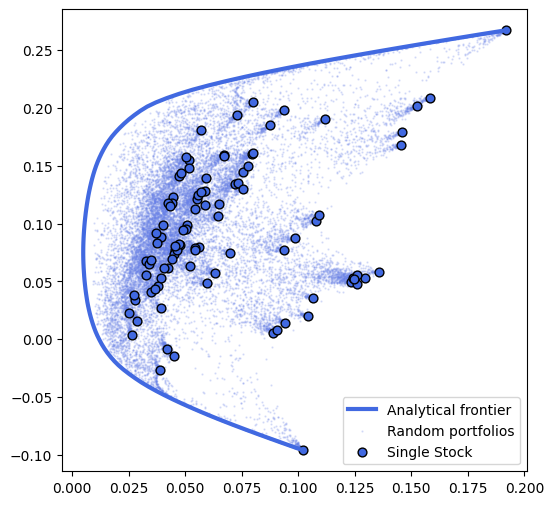

In [8]:
# Build the efficient frontier by solving the min-variance portfolio
# for a sequence of target returns. This produces (risk,return) pairs.

# Asset-level statistics for plotting individual points
asset_returns = mu.copy()
asset_stdevs  = df_return.std(axis=1)

plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3)
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2)
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40)
# plt.tight_layout()
plt.legend(['Analytical frontier', 'Random portfolios', 'Single Stock'], loc='lower right')
plt.savefig(f'Results/Portfolio_Frontier{clean}.png', dpi=144, transparent=True)
plt.show()

## ESG-Constrained Efficient Frontier

In this step we extend the classical **Markowitz efficient frontier** by introducing **responsible investing and diversification rules**.  
The goal is to understand how the trade-off between risk and return changes once we require the portfolio to satisfy ESG and structural constraints.

---

### Why this extension?
- **Classical Markowitz** assumes only risk (variance) and return matter.  
- In practice, institutional investors also require:
  - Minimum **sustainability profile** (average ESG score above a threshold),  
  - **Diversification** across many assets,  
  - **Sector concentration limits**,  
  - **Upper and lower bounds** on single positions.

Adding these rules makes the problem closer to **real-world portfolio construction**.

---

### Strategy
1. We scan across a range of target returns.  
   For each return level, we solve an optimization problem that finds the portfolio with the **lowest possible volatility** subject to all constraints.

2. The optimization is more complex than in the unconstrained case:
   - We introduce binary variables to decide whether an asset is included.  
   - Linking weight variables to selection variables enforces minimum and maximum size rules.  
   - Sector caps ensure that no sector dominates the portfolio.  
   - A diversification constraint forces the model to hold a sufficiently large number of assets.

3. By repeating this for multiple target returns, we obtain a **constrained efficient frontier**:  
   - It shows the best achievable trade-offs when ESG and diversification requirements are respected.  
   - Compared to the unconstrained frontier, it is typically **shifted inward** (less efficient in pure risk-return terms),  
     but it represents **feasible and more realistic investment choices**.

---

### Interpretation
The resulting `frontier_esg_df` contains a sequence of optimized portfolios that balance:
- **Return objectives**,  
- **Risk minimization**,  
- **Sustainability + diversification rules**.  

This provides a practical picture of how ESG integration affects attainable risk–return profiles.



In [9]:
# --- Build expected returns (mu) and covariance matrix (Sigma) ---
# These are the fundamental inputs of the Markowitz framework.
# mu = expected return per asset, Sigma = covariance of returns.

esg = df_info['ESG score'].astype(int).values   # ESG score for each asset
sectors = df_info['Sector'].tolist()            # sector classification
unique_sectors = sorted(set(sectors))           # list of unique sectors

# --- Constraint parameters ---
esg_min = 70.0          # minimum average ESG score required for the portfolio
target_return = 0.05    # reference target return (not directly used in loop)
max_w_per_asset = 0.20  # maximum allocation per single asset
min_w_if_selected = 0.01 # minimum allocation if an asset is included
max_w_per_sector = 0.25  # maximum allocation per sector
min_n_assets = 50        # minimum number of assets in the portfolio

frontier_esg = []  # will collect all solutions for the ESG-efficient frontier

# --- Loop across target returns to trace the ESG frontier ---
for tr in tqdm(np.linspace(0, mu.max(), 100), total=100, desc="Building ESG frontier"):
    # Define a new optimization problem
    prob = xp.problem()
    prob.controls.outputlog = 0   # suppress solver logs
    prob.controls.maxtime = 10    # time limit per problem (seconds)

    # Decision variables:
    # w[i] = portfolio weight of asset i (continuous)
    # y[i] = selection variable (binary: 1 if asset is included, 0 otherwise)
    w = [prob.addVariable(lb=0, ub=1, name=f'w{i}') for i in range(len(df_cov))]
    y = [prob.addVariable(vartype=xp.binary, name=f'y{i}') for i in range(len(df_cov))]

    # Objective: minimize portfolio variance (quadratic form w' Σ w)
    quad = xp.Sum(Sigma[i, j] * w[i] * w[j] for i in range(len(df_cov)) for j in range(len(df_cov)))
    prob.setObjective(quad, sense=xp.minimize)

    # --- Core constraints ---
    prob.addConstraint(xp.Sum(w) == 1)  # fully invested portfolio
    prob.addConstraint(xp.Sum([mu[i] * w[i] for i in range(len(df_cov))]) >= tr)   # required return
    prob.addConstraint(xp.Sum([esg[i] * w[i] for i in range(len(df_cov))]) >= float(esg_min))  # ESG requirement

    # --- Asset-level constraints ---
    for i in range(len(df_cov)):
        # If an asset is selected, enforce min/max weight bounds
        prob.addConstraint(w[i] <= max_w_per_asset * y[i])
        prob.addConstraint(w[i] >= min_w_if_selected * y[i])

    # --- Sector-level constraints ---
    for sec in unique_sectors:
        idx = [i for i, sct in enumerate(sectors) if sct == sec]
        if idx:  # only if sector exists in dataset
            prob.addConstraint(xp.Sum(w[i] for i in idx) <= max_w_per_sector)

    # --- Diversification constraint ---
    prob.addConstraint(xp.Sum(y) >= int(min_n_assets))

    # Solve optimization problem
    prob.optimize()

    # If a valid solution is found, extract portfolio metrics
    if prob.attributes.mipstatus in (MIPStatus.OPTIMAL, MIPStatus.SOLUTION):
        w_val = np.array([prob.getSolution(w[i]) for i in range(len(df_cov))])  # optimal weights
        port_return = float(np.dot(mu, w_val))   # achieved return
        port_var = float(w_val @ Sigma @ w_val)  # portfolio variance
        port_std = np.sqrt(port_var)             # portfolio volatility (stdev)

        # Save solution for this target return
        frontier_esg.append({
            "target_return": tr,
            "achieved_return": port_return,
            "variance": port_var,
            "stdev": port_std,
            "weights": w_val
        })

# Collect all solutions in a DataFrame for later analysis and plotting
frontier_esg_df = pd.DataFrame(frontier_esg)


Building ESG frontier: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


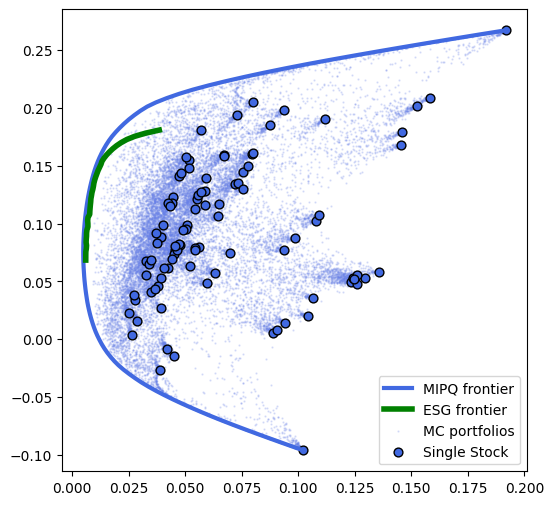

In [10]:
plt.figure(figsize=(6, 6))
# plt.plot(Sigma_m, m, color='k', linestyle='--', linewidth=2)
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3)
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4)
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2)
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40)
# plt.tight_layout()
plt.legend(['MIPQ frontier','ESG frontier', 'MC portfolios', 'Single Stock'], loc='lower right')
plt.savefig(f'Results/Portfolio_Frontier_ESG{clean}.png', dpi=144, transparent=True)
plt.show()

## Brown Frontier (Low-ESG Portfolios)

In this step we construct the **Brown efficient frontier**:  
portfolios that are risk-return efficient, but explicitly constrained to have **low ESG exposure**.  

This setup is useful as a **counterfactual comparison** to the ESG frontier, showing how portfolio characteristics change when we deliberately favor lower-ESG companies.

---

### Optimization problem

We solve the following quadratic program:

\[
\begin{aligned}
\min_{w} & \quad w^\top \Sigma w  \quad && \text{(minimize portfolio variance)} \\
\text{s.t.} & \quad \sum_i w_i = 1 \quad && \text{(fully invested)} \\
& \quad \sum_i \mu_i w_i \geq \text{Target return} \quad && \text{(return constraint)} \\
& \quad \color{red}{\sum_i ESG_i \, w_i \leq ESG_{\max}} \quad && \color{red}{\text{(force ESG exposure to remain low)}} \\
& \quad 0 \leq w_i \leq y_i \cdot w^{\max} \quad && \text{(asset-level bounds)} \\
& \quad w_i \geq y_i \cdot w^{\min} \quad && \text{(min if selected)} \\
& \quad \sum_{i \in \text{sector } s} w_i \leq w^{\max}_{sector}, \quad \forall s \quad && \text{(sector diversification)} \\
& \quad \sum_i y_i \geq N_{\min} \quad && \text{(minimum number of assets)} \\
& \quad y_i \in \{0,1\}, \; \forall i \quad && \text{(binary selection vars)} \\
\end{aligned}
\]


In [11]:
esg_max = 60.0   # maximum allowed average ESG score

frontier_brown = []  # list to store all optimal portfolios along the frontier

# Sweep over target returns to trace the frontier
for tr in tqdm(np.linspace(0, mu.max(), 100), total=100, desc="Building Brown frontier"):
    # Initialize optimization problem
    prob = xp.problem()
    prob.controls.outputlog = 0   # suppress solver logs
    prob.controls.maxtime = 10    # time limit in seconds

    # Decision variables:
    # w[i] = portfolio weight of asset i
    # y[i] = binary selection variable (1 if asset is included)
    w = [prob.addVariable(lb=0, ub=1, name=f'w{i}') for i in range(len(df_cov))]
    y = [prob.addVariable(vartype=xp.binary, name=f'y{i}') for i in range(len(df_cov))]

    # Objective: minimize portfolio variance (quadratic form w' Σ w)
    quad = xp.Sum(Sigma[i, j] * w[i] * w[j] 
                  for i in range(len(df_cov)) for j in range(len(df_cov)))
    prob.setObjective(quad, sense=xp.minimize)

    # --- Core constraints ---
    prob.addConstraint(xp.Sum(w) == 1)  # fully invested
    prob.addConstraint(xp.Sum([mu[i] * w[i] for i in range(len(df_cov))]) >= tr)  # target return
    prob.addConstraint(xp.Sum([esg[i] * w[i] for i in range(len(df_cov))]) <= float(esg_max))  # ESG cap

    # --- Asset-level constraints ---
    for i in range(len(df_cov)):
        # Limit weight per asset, and enforce minimum if selected
        prob.addConstraint(w[i] <= max_w_per_asset * y[i])
        prob.addConstraint(w[i] >= min_w_if_selected * y[i])

    # --- Sector-level diversification constraints ---
    for sec in unique_sectors:
        idx = [i for i, sct in enumerate(sectors) if sct == sec]
        if idx:  # add sector constraint only if assets exist in this sector
            prob.addConstraint(xp.Sum(w[i] for i in idx) <= max_w_per_sector)

    # --- Diversification constraint (number of assets) ---
    prob.addConstraint(xp.Sum(y) >= int(min_n_assets))

    # Solve the optimization problem
    prob.optimize()

    # If solution is found, extract portfolio stats
    if prob.attributes.mipstatus in (MIPStatus.OPTIMAL, MIPStatus.SOLUTION):
        w_val = np.array([prob.getSolution(w[i]) for i in range(len(df_cov))])  # optimal weights
        port_return = float(np.dot(mu, w_val))   # realized return
        port_var = float(w_val @ Sigma @ w_val)  # portfolio variance
        port_std = np.sqrt(port_var)             # portfolio volatility (std dev)
        
        # Store result for this target return
        frontier_brown.append({
            "target_return": tr,
            "achieved_return": port_return,
            "variance": port_var,
            "stdev": port_std,
            "weights": w_val
        })

# Collect all Brown frontier portfolios into a DataFrame
frontier_nesg_df = pd.DataFrame(frontier_brown)

Building Brown frontier: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


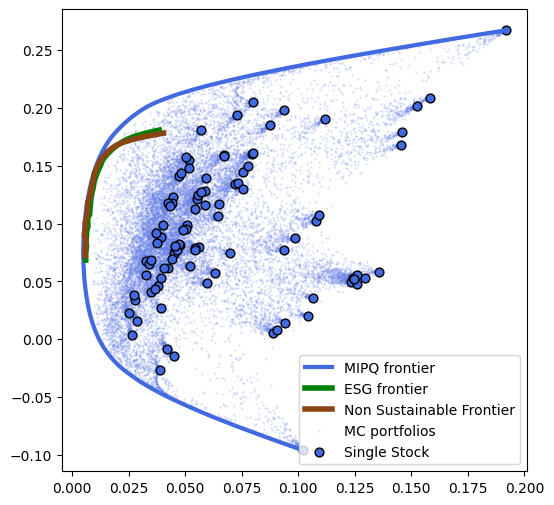

In [12]:
plt.figure(figsize=(6, 6))
# plt.plot(Sigma_m, m, color='k', linestyle='--', linewidth=2)
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3)
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label="Green Frontier")
plt.plot(frontier_nesg_df["stdev"], frontier_nesg_df["achieved_return"], color='saddlebrown', linewidth=4, label="Brown Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2)
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40)
# plt.tight_layout()
plt.legend(['MIPQ frontier','ESG frontier','Non Sustainable Frontier', 'MC portfolios', 'Single Stock'], loc='lower right')
plt.savefig(f'Results/Portfolio_Frontier_ESG_Brown{clean}.png', dpi=144, transparent=True)
plt.show()


In [13]:
frontier_esg_df = frontier_esg_df.sort_values(by="achieved_return", ascending=True).reset_index(drop=True)
frontier_nesg_df = frontier_nesg_df.sort_values(by="achieved_return", ascending=True).reset_index(drop=True)

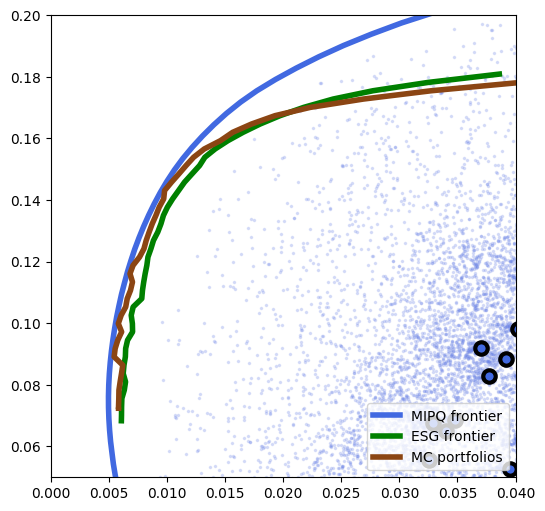

In [14]:
plt.figure(figsize=(6, 6))
# plt.plot(Sigma_m, m, color='k', linestyle='--', linewidth=4)
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=4)
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label="Green Frontier")
plt.plot(frontier_nesg_df["stdev"], frontier_nesg_df["achieved_return"], color='saddlebrown', linewidth=4, label="Brown Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=2.5, c='#6881E7', alpha=0.2)
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=3, s=80)
plt.xlim(0, 0.04)
plt.ylim(0.05, 0.2)
# plt.tight_layout()
plt.legend(['MIPQ frontier','ESG frontier', 'MC portfolios'], loc='lower right')

plt.savefig(f'Results/Portfolio_Frontier_ESG_Brown_Zoom{clean}.png', dpi=144, transparent=True)
plt.show()

## ESG Frontier vs Benchmark Portfolios

In this cell, we visualize the efficient frontiers (with and without ESG constraints) 
and compare them against two standard benchmark portfolios:

- **Equal Weights (EW):** Each asset receives the same weight, regardless of risk or return.  
- **Inverse Volatility Weights (IVW):** Assets with lower volatility receive higher weights, 
  which reduces overall portfolio risk.

The plot shows:

- **Blue line:** Efficient frontier from the MIQP optimization.  
- **Green line:** Efficient frontier with ESG constraints applied.  
- **Light-blue dots:** Randomly generated Monte Carlo portfolios.  
- **Black-edged blue dots:** Individual assets (volatility vs expected return).  
- **Red "X":** Equal Weights benchmark.  
- **Orange diamond:** Inverse Volatility Weights benchmark.  

This comparison highlights how ESG constraints shift the efficient frontier 
and where common benchmark portfolios lie relative to the optimized solutions.


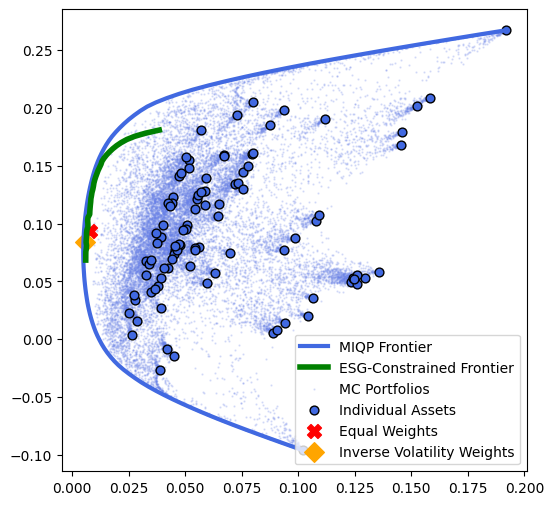

In [15]:
# --- Load benchmark portfolio weights ---
# Equal Weights (EW) and Inverse Volatility Weights (IVW) have been precomputed and saved as CSVs.

EW = pd.read_csv(f'Results/Benchmark Portfolios/Equal_Weights.csv')
IVW = pd.read_csv(f'Results/Benchmark Portfolios/Inverse_Volatility_Weights.csv')

# Extract portfolio weights and compute return/volatility for Equal Weights
w_ew = EW['0'].to_numpy()
ret_ew = float(mu @ w_ew)                          # expected return
vol_ew = float(np.sqrt(w_ew @ Sigma @ w_ew))       # standard deviation (risk)

# Extract portfolio weights and compute return/volatility for Inverse Volatility Weights
w_ivw = IVW['0'].to_numpy()
ret_ivw = float(mu @ w_ivw)
vol_ivw = float(np.sqrt(w_ivw @ Sigma @ w_ivw))

# --- Plot efficient frontiers and benchmarks ---
plt.figure(figsize=(6, 6))

# Plot the MIQP frontier (baseline optimization, no ESG constraints)
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"],
         color='royalblue', linewidth=3, label='MIQP Frontier')

# Plot the ESG-constrained frontier
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"],
         color='green', linewidth=4, label='ESG-Constrained Frontier')

# Plot Monte Carlo simulated portfolios (random sampling)
plt.scatter(port_df['Volatility'], port_df['Return'],
            s=0.5, c='#6881E7', alpha=0.2, label='MC Portfolios')

# Plot individual assets (risk-return profile)
plt.scatter(asset_stdevs, asset_returns,
            facecolors='royalblue', edgecolors='k', linewidths=1, s=40,
            label='Individual Assets')

# Highlight benchmark portfolios
plt.scatter(vol_ew, ret_ew, c='red', marker='X', s=100, label='Equal Weights')
plt.scatter(vol_ivw, ret_ivw, c='orange', marker='D', s=100, label='Inverse Volatility Weights')

# Add legend and display the plot
plt.legend(loc='best')
plt.savefig(f'Results/ESG Frontier vs Benchmarks{clean}.png', transparent=True, dpi=144)
plt.show()


### Expanding and Saving Frontier Portfolios

In the previous steps, each efficient frontier (`frontier_df`, `frontier_esg_df`, `frontier_nesg_df`) 
contained a `"weights"` column, where the portfolio allocation vector was stored as a nested array.  
This format is compact but not convenient for external analysis.

In this cell, we:

1. Define a helper function `parse_weights` to convert stored weight vectors 
   (strings, lists, or arrays) into NumPy arrays.
2. Define `expand_frontier`, which:
   - Stacks all weight vectors into a matrix (`wmat`),
   - Expands them into separate columns (one per asset),
   - Concatenates these columns with the portfolio-level statistics 
     (return, variance, stdev, etc.),
   - Saves the expanded DataFrame to CSV.
3. Apply `expand_frontier` to:
   - the **baseline frontier** (`frontier_df`),
   - the **ESG frontier** (`frontier_esg_df`),
   - the **Brown frontier** (`frontier_nesg_df`).

The result is three CSV files (one for each frontier), where every row corresponds 
to a portfolio and includes both risk/return metrics and the explicit asset weights.
This makes it easy to inspect or visualize portfolio compositions outside Python.


In [16]:
def parse_weights(s):
    if isinstance(s, str):
        return np.array(s.strip("[]").split(), dtype=float)
    elif isinstance(s, (list, np.ndarray)):
        return np.array(s, dtype=float)
    else:
        raise ValueError(f"Unexpected type: {type(s)}")

def expand_frontier(df_in, asset_cols, out_path):
    wmat = np.vstack(df_in["weights"].apply(parse_weights).to_numpy())
    # Fallback if dimension mismatch
    if len(asset_cols) != wmat.shape[1]:
        asset_cols = [f"asset_{i}" for i in range(wmat.shape[1])]
    wdf = pd.DataFrame(wmat, columns=asset_cols)
    df_out = pd.concat([df_in.drop(columns=["weights"]), wdf], axis=1)
    df_out.to_csv(out_path, index=False)
    return df_out

# Prefer the covariance index ordering (matches optimization variable order)
asset_cols = df_cov.index.tolist()

# Apply to the three frontiers
frontier_expanded       = expand_frontier(frontier_df,        asset_cols, f"Results/frontier_expanded{clean}.csv")
frontier_esg_expanded   = expand_frontier(frontier_esg_df,    asset_cols, f"Results/frontier_esg_expanded{clean}.csv")
frontier_nesg_expanded  = expand_frontier(frontier_nesg_df,   asset_cols, f"Results/frontier_nesg_expanded{clean}.csv")

In [17]:
frontier_expanded.to_csv(f'Results/frontier_df{clean}.csv')
frontier_esg_expanded.to_csv(f'Results/frontier_esg_df{clean}.csv')
frontier_nesg_expanded.to_csv(f'Results/frontier_nesg_df{clean}.csv')

## Tangency Portfolio (Maximum Sharpe Ratio)

In this step we identify the **Tangency Portfolio** on each efficient frontier:

- **Original frontier** (no ESG constraints),  
- **Green frontier** (with ESG ≥ threshold),  
- **Brown frontier** (with ESG ≤ threshold).  

The tangency portfolio is the allocation that **maximizes the Sharpe ratio**:

$$
\text{Sharpe}(w) = \frac{\mathbb{E}[R_p] - r_f}{\sigma_p}
$$

where:  
- $\mathbb{E}[R_p]$ is the portfolio expected return,  
- $\sigma_p$ is the portfolio volatility,  
- $r_f$ is the risk-free rate (here assumed to be 0).  

For each frontier, we:  
1. Compute the Sharpe ratio for all portfolios,  
2. Find the portfolio with the maximum Sharpe ratio,  
3. Extract its weights, return, volatility, and Sharpe value,  
4. Save both the **weights** and a **summary** (risk/return/Sharpe) as CSV files.  

This allows us to compare the "best risk-adjusted" portfolio across different constraint sets (unconstrained, ESG, Brown).  


In [18]:
# --- Tangency Portfolio (maximum Sharpe ratio) ---
rf = 0.0  # Assume zero risk-free rate for simplicity

# === Original Frontier ===
# Compute Sharpe ratio for each portfolio
frontier_df["sharpe"] = (frontier_df["achieved_return"] - rf) / frontier_df["stdev"]

# Find index of the portfolio with maximum Sharpe ratio
idx_tan = frontier_df["sharpe"].idxmax()

# Extract metrics and weights
tan_ret = float(frontier_df.loc[idx_tan, "achieved_return"])
tan_vol = float(frontier_df.loc[idx_tan, "stdev"])
tan_w   = np.array(frontier_df.loc[idx_tan, "weights"])

# === Green Frontier (ESG-constrained) ===
frontier_esg_df["sharpe"] = (frontier_esg_df["achieved_return"] - rf) / frontier_esg_df["stdev"]
idx_tan_esg = frontier_esg_df["sharpe"].idxmax()
tan_ret_esg = float(frontier_esg_df.loc[idx_tan_esg, "achieved_return"])
tan_vol_esg = float(frontier_esg_df.loc[idx_tan_esg, "stdev"])
tan_w_esg   = np.array(frontier_esg_df.loc[idx_tan_esg, "weights"])

# === Brown Frontier (low ESG portfolios) ===
frontier_nesg_df["sharpe"] = (frontier_nesg_df["achieved_return"] - rf) / frontier_nesg_df["stdev"]
idx_tan_b = frontier_nesg_df["sharpe"].idxmax()
tan_ret_b = float(frontier_nesg_df.loc[idx_tan_b, "achieved_return"])
tan_vol_b = float(frontier_nesg_df.loc[idx_tan_b, "stdev"])
tan_w_b   = np.array(frontier_nesg_df.loc[idx_tan_b, "weights"])

# --- Save results to CSV ---
os.makedirs('Results/Tangency', exist_ok=True)

# Save portfolio weights for each frontier
pd.DataFrame({"asset": df_cov.index.tolist(), "weight": tan_w}).to_csv(
    f"Results/Tangency/tangency_original_weights{clean}.csv", index=False
)
pd.DataFrame({"asset": df_cov.index.tolist(), "weight": tan_w_esg}).to_csv(
    f"Results/Tangency/tangency_green_weights{clean}.csv", index=False
)
pd.DataFrame({"asset": df_cov.index.tolist(), "weight": tan_w_b}).to_csv(
    f"Results/Tangency/tangency_brown_weights{clean}.csv", index=False
)

# Save portfolio summaries (risk/return/Sharpe)
pd.DataFrame([{
    "frontier": "original", "rf": rf, "return": tan_ret, "vol": tan_vol,
    "sharpe": (tan_ret - rf) / tan_vol
}]).to_csv(f"Results/Tangency/tangency_original_summary{clean}.csv", index=False)

pd.DataFrame([{
    "frontier": "green", "rf": rf, "return": tan_ret_esg, "vol": tan_vol_esg,
    "sharpe": (tan_ret_esg - rf) / tan_vol_esg
}]).to_csv(f"Results/Tangency/tangency_green_summary{clean}.csv", index=False)

pd.DataFrame([{
    "frontier": "brown", "rf": rf, "return": tan_ret_b, "vol": tan_vol_b,
    "sharpe": (tan_ret_b - rf) / tan_vol_b
}]).to_csv(f"Results/Tangency/tangency_brown_summary{clean}.csv", index=False)


## Visualization
On each chart we plot:
- The **efficient frontier(s)** obtained with MIQP,  
- A cloud of **Monte Carlo simulated portfolios** for reference,  
- The positions of **individual assets**,  
- The **tangency portfolio(s)** (maximum Sharpe ratio) highlighted with a star,  
- The **Capital Allocation Line (CAL)** starting from the risk-free asset.  

We also include benchmarks such as:
- **Equal Weights portfolio (EW)**,  
- **Inverse-Volatility Weights portfolio (IVW)**.  

Some plots show **zoomed-in views** to better compare ESG vs Brown vs Unconstrained frontiers, especially around the tangency points.  

These visualizations make it possible to **compare portfolio efficiency** across different ESG constraints and benchmark allocations.  


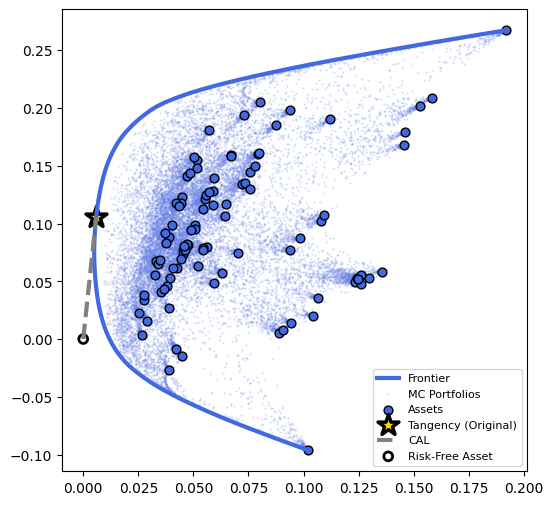

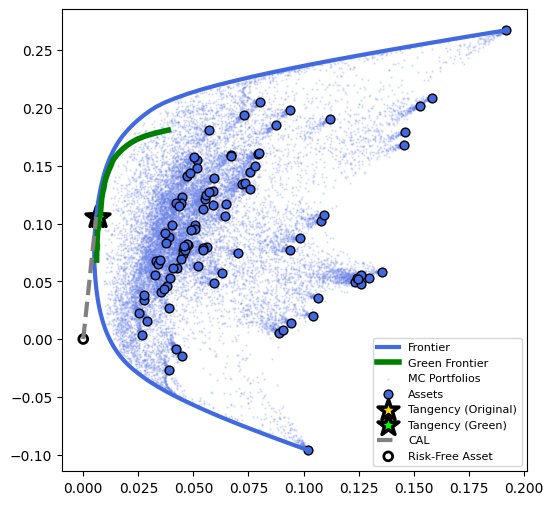

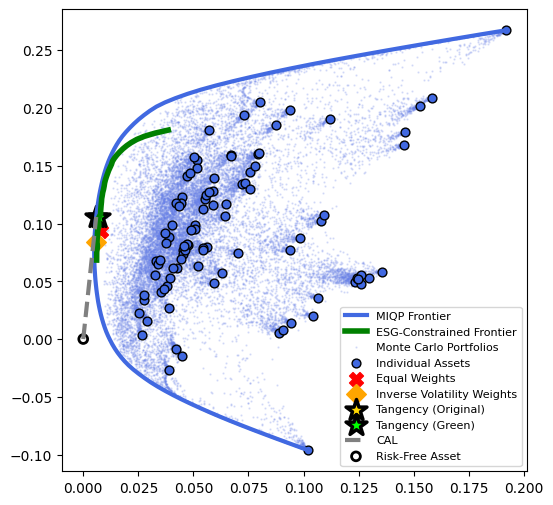

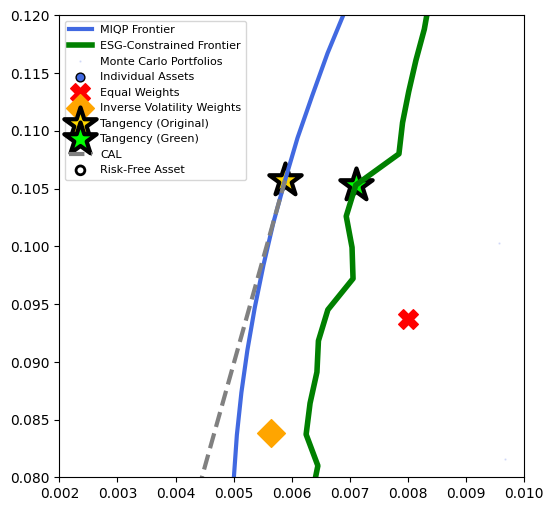

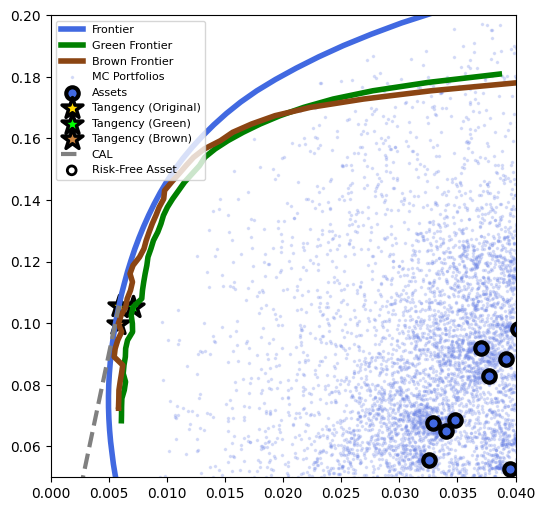

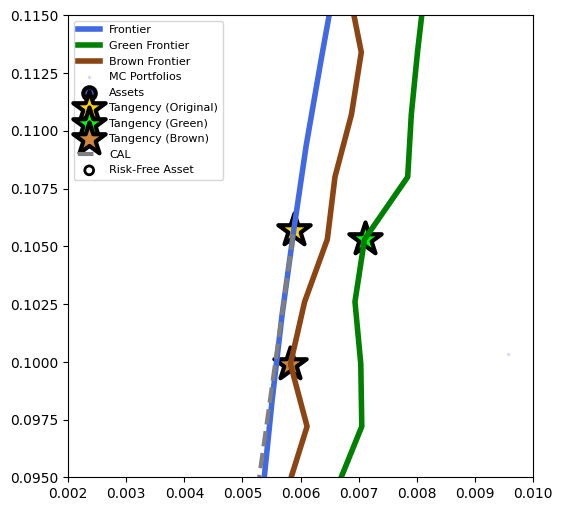

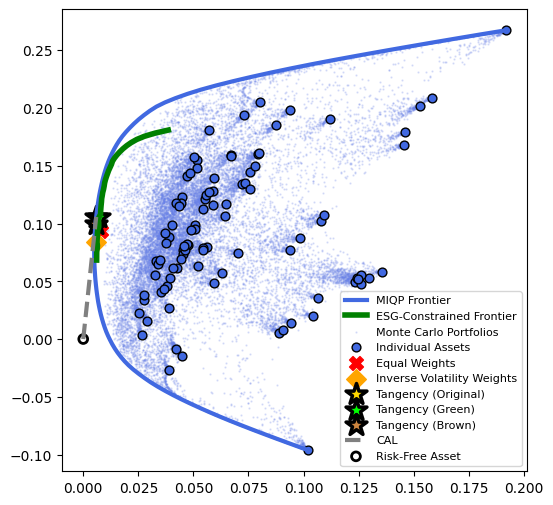

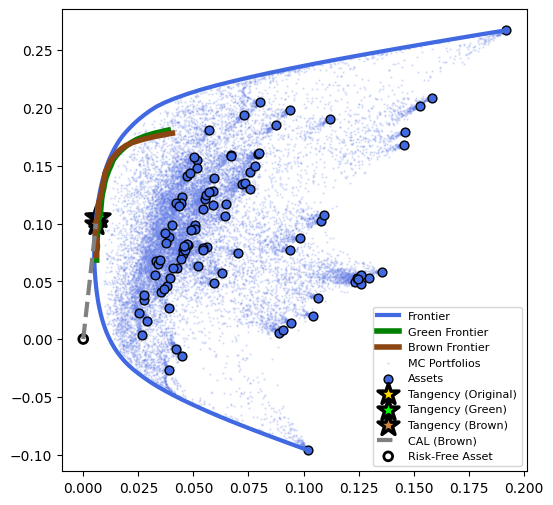

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3, label="Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios")
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40, label="Assets")

# Tangency (Original)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Original)')
# CAL + rf
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/Portfolio_Frontier{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3, label="Frontier")
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label="Green Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios")
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40, label="Assets")

# Tangency (Original & Green)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Green)')
# CAL + rf (Green)
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/Portfolio_Frontier_ESG{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3, label='MIQP Frontier')
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label='ESG-Constrained Frontier')
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2, label='Monte Carlo Portfolios')
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40, label='Individual Assets')

plt.scatter(vol_ew, ret_ew, c='red', marker='X', s=100, label='Equal Weights')
plt.scatter(vol_ivw, ret_ivw, c='orange', marker='D', s=100, label='Inverse Volatility Weights')

# Tangency (Original / Green / Brown)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Green)')
# CAL + rf (Original)
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/ESG_Frontier_vs_Benchmarks{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3, label='MIQP Frontier')
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label='ESG-Constrained Frontier')
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2, label='Monte Carlo Portfolios')
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40, label='Individual Assets')

plt.scatter(vol_ew, ret_ew, c='red', marker='X', s=200, label='Equal Weights')
plt.scatter(vol_ivw, ret_ivw, c='orange', marker='D', s=200, label='Inverse Volatility Weights')

# Tangency (Original / Green / Brown)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=600, linewidths=3, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=600, linewidths=3, label='Tangency (Green)')
# CAL + rf (Original)
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.legend(loc='best', fontsize=8)
plt.xlim(0.002, 0.01)
plt.ylim(0.08, 0.12)
plt.savefig(f'Results/ESG_Frontier_vs_Benchmarks_Zoom{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=4, label="Frontier")
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label="Green Frontier")
plt.plot(frontier_nesg_df["stdev"], frontier_nesg_df["achieved_return"], color='saddlebrown', linewidth=4, label="Brown Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=2.5, c='#6881E7', alpha=0.2, label="MC Portfolios")
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=3, s=80, label="Assets")

# Tangency (Original / Green / Brown)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Green)')
plt.scatter(tan_vol_b, tan_ret_b, c='peru', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Brown)')
# CAL + rf (Brown)
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.xlim(0, 0.04)
plt.ylim(0.05, 0.2)
plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/Portfolio_Frontier_ESG_Brown_Zoom{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=4, label="Frontier")
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label="Green Frontier")
plt.plot(frontier_nesg_df["stdev"], frontier_nesg_df["achieved_return"], color='saddlebrown', linewidth=4, label="Brown Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=2.5, c='#6881E7', alpha=0.2, label="MC Portfolios")
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=3, s=80, label="Assets")

# Tangency (Original / Green / Brown)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=600, linewidths=3, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=600, linewidths=3, label='Tangency (Green)')
plt.scatter(tan_vol_b, tan_ret_b, c='peru', edgecolors='k', marker='*', s=600, linewidths=3, label='Tangency (Brown)')
# CAL + rf (Brown)
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.xlim(0.002, 0.01)
plt.ylim(0.095, 0.115)
plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/Portfolio_Frontier_ESG_Brown_Zoom_Close{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3, label='MIQP Frontier')
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label='ESG-Constrained Frontier')
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2, label='Monte Carlo Portfolios')
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40, label='Individual Assets')

plt.scatter(vol_ew, ret_ew, c='red', marker='X', s=100, label='Equal Weights')
plt.scatter(vol_ivw, ret_ivw, c='orange', marker='D', s=100, label='Inverse Volatility Weights')

# Tangency (Original / Green / Brown)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Green)')
plt.scatter(tan_vol_b, tan_ret_b, c='peru', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Brown)')
# CAL + rf (Original)
plt.plot([0, tan_vol], [rf, tan_ret], linestyle='--', color='gray', linewidth=3, label='CAL')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/ESG_Frontier_vs_Benchmarks_All{clean}.png', dpi=144, transparent=True)
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"], color='royalblue', linewidth=3, label="Frontier")
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"], color='green', linewidth=4, label="Green Frontier")
plt.plot(frontier_nesg_df["stdev"], frontier_nesg_df["achieved_return"], color='saddlebrown', linewidth=4, label="Brown Frontier")
plt.scatter(port_df['Volatility'], port_df['Return'], s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios")
plt.scatter(asset_stdevs, asset_returns, facecolors='royalblue', edgecolors='k', linewidths=1, s=40, label="Assets")

# Tangency (Original / Green / Brown)
plt.scatter(tan_vol, tan_ret, c='gold', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Original)')
plt.scatter(tan_vol_esg, tan_ret_esg, c='lime', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Green)')
plt.scatter(tan_vol_b, tan_ret_b, c='peru', edgecolors='k', marker='*', s=250, linewidths=2.5, label='Tangency (Brown)')
# CAL + rf
plt.plot([0, tan_vol_b], [rf, tan_ret_b], linestyle='--', color='gray', linewidth=3, label='CAL (Brown)')
plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40, linewidths=2, label='Risk-Free Asset')

plt.legend(loc='best', fontsize=8)
plt.savefig(f'Results/Portfolio_Frontier_ESG_Brown{clean}.png', dpi=144, transparent=True)
plt.show()

